# **Khushdev Pandit**
# **Roll no: 2020211** 
# *Assignment Question-2*

In [43]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import torch.nn.functional as F
import cv2
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report

# **Q2 Part-1**


## **2(a)** *Download the training files. Use 20% of the training dataset for validation and 10% for testing. Initialize Weights & Biases (WandB).*

In [6]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

In [45]:
path_data_img = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q2/images"
path_data_mask = "/content/drive/MyDrive/ECE344: CV (Computer Vision)/Assignments/Assignment-1/Q2/masks"
path_data_img = "VOC Segmentation Dataset\images"
path_data_mask = "VOC Segmentation Dataset\masks"
print(len(os.listdir(path_data_img)))
print(len(os.listdir(path_data_mask)))

1464
1464


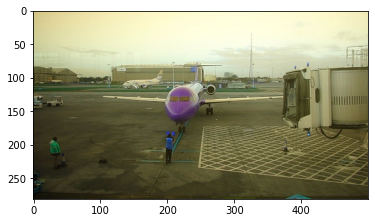

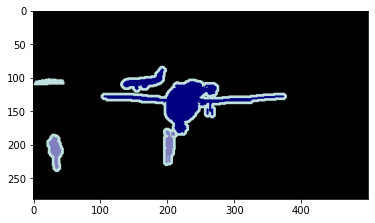

In [46]:
img = cv2.imread(os.path.join(path_data_img, os.listdir(path_data_img)[0]))
mask = cv2.imread(os.path.join(path_data_mask, os.listdir(path_data_mask)[0]))
plt.imshow(img);
plt.show()
plt.imshow(mask);
plt.show()

In [47]:
np.unique(mask, return_counts=True)

(array([  0, 128, 192, 224], dtype=uint8),
 array([398103,   6466,   6221,  10710], dtype=int64))

In [48]:
max_row_size, max_col_size = 0, 0
min_row_size, min_col_size = 100000, 100000
images, masks = [], []
for i, img_file in enumerate(os.listdir(path_data_img)):
    mask_file = img_file[:-4]+'.png'
    image_ = cv2.imread(os.path.join(path_data_img, img_file))
    label_ = cv2.imread(os.path.join(path_data_mask, mask_file))
    images.append(image_)
    masks.append(label_)
    max_row_size = max(max_row_size, image_.shape[0])
    max_col_size = max(max_col_size, image_.shape[1])
    min_row_size = min(min_row_size, image_.shape[0])
    min_col_size = min(min_col_size, image_.shape[1])

In [49]:
print('Number of Images and Masks:', len(images), len(masks))
print('Max and Min Row Size:', max_row_size, min_row_size)
print('Max and Min Col Size:', max_col_size, min_col_size)

Number of Images and Masks: 1464 1464
Max and Min Row Size: 500 112
Max and Min Col Size: 500 246


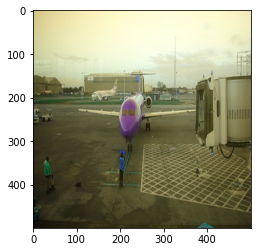

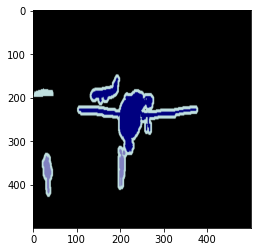

In [50]:
# resize img to 500x500
img2 = cv2.resize(img, (500, 500))
plt.imshow(img2);
plt.show()
mask2 = cv2.resize(mask, (500, 500))
plt.imshow(mask2);
plt.show()

In [51]:
# calculate the indices for the splits
val_split = int(0.2 * len(images))
test_split = int(0.1 * len(images))

# create the splits
train_images = images[val_split+test_split:]
val_images = images[:val_split]
test_images = images[val_split:val_split+test_split]
train_masks = masks[val_split+test_split:]
val_masks = masks[:val_split]
test_masks = masks[val_split:val_split+test_split]

print(len(train_images), len(val_images), len(test_images))
print(len(train_masks), len(val_masks), len(test_masks))

1026 292 146
1026 292 146


## **2(b)** *Create dataloaders for all the splits (train, val and test) using Py-Torch to load the images and their corresponding segmentation masks.*

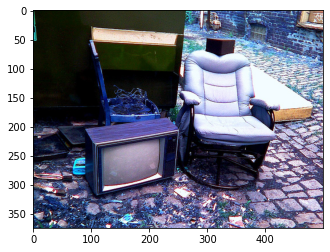

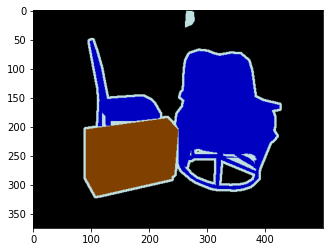

[  3 375 500]
(array([0.       , 0.2509804, 0.5019608, 0.7529412, 0.8784314],
      dtype=float32), array([469227,  16973,  16973,  41019,  18308], dtype=int64))


In [66]:
class VOC2012Dataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

# define the transforms
transform1 = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((356, 356))
])
transform2 = transforms.Compose([
    transforms.ToTensor()]
)

# Datset for training, validation and testing
train_dataset = VOC2012Dataset(train_images, train_masks, transform=transform1)
val_dataset = VOC2012Dataset(val_images, val_masks, transform=transform1)
test_dataset = VOC2012Dataset(test_images, test_masks, transform=transform2)

plt.imshow(train_dataset.__getitem__(1)[0].permute(1, 2, 0)); plt.show()
plt.imshow(train_dataset.__getitem__(1)[1].permute(1, 2, 0)); plt.show()
print(np.unique(train_dataset.__getitem__(1)[1].shape))
print(np.unique(train_dataset.__getitem__(1)[1].permute(1, 2, 0), return_counts=True))

In [67]:
# create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

len(train_loader), len(val_loader), len(test_loader)

(33, 10, 5)

## **2(c)** *Visualize the data distribution across class labels for training and validation sets.*

In [54]:
# get the class labels
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
        'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
        'sheep', 'sofa', 'train', 'tvmonitor']

# get the class counts for the training set
train_counts = np.zeros(len(classes))
for i, (image, mask) in enumerate(train_loader):
    if i == 0:
        print(mask.shape)
    mask = mask.numpy()
    # mask = np.argmax(mask, axis=1)
    # print(mask.shape)
    # print(np.max(mask))
    # break
    for j in range(len(classes)):
        train_counts[j] += np.sum(mask == j)


# get the class counts for the validation set
# val_counts = np.zeros(len(classes))
# for i, (image, mask) in enumerate(val_loader):
#     mask = mask.permute(1, 2, 0).numpy()
#     mask = np.argmax(mask, axis=1)
#     for j in range(len(classes)):
#         val_counts[j] += np.sum(mask == j)

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 334, 500] at entry 3

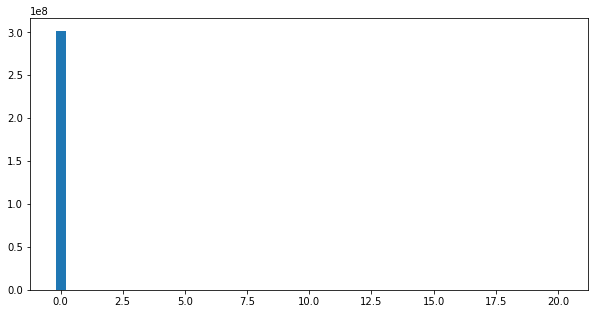

In [ ]:
# plot the class distribution for the training and validation sets
plt.figure(figsize=(10, 5))
plt.bar(np.arange(len(classes)), train_counts, width=0.4, label='Training set class distribution')
# plt.tight_layout()
plt.show()